In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/demand-forecasting-kernels-only/sample_submission.csv
/kaggle/input/demand-forecasting-kernels-only/train.csv
/kaggle/input/demand-forecasting-kernels-only/test.csv


In [2]:
df=pd.read_csv('/kaggle/input/demand-forecasting-kernels-only/train.csv')

In [ ]:
df = df[(df['store'] == 1) & (df['item'] == 1)] # item 1 in store 1
df = df.set_index('date')
y = df['sales']
y_to_train = y.iloc[:(len(y)-365)]
y_to_test = y.iloc[(len(y)-365):]

In [3]:
df = df[(df['store'] == 1) & (df['item'] == 1)]
df['date']=pd.to_datetime(df['date'])
y = df['sales']

x_to_test=df.drop(['sales'],axis=1).iloc[(len(y)-365):]
y_to_train = y.iloc[:(len(y)-365)]
y_to_test = y.iloc[(len(y)-365):]

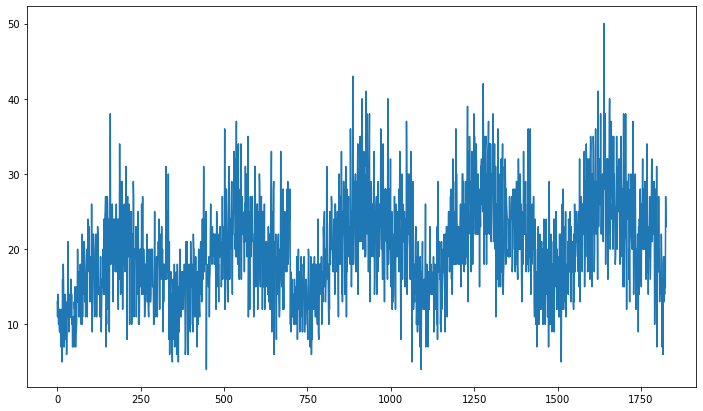

In [4]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
plt.figure(figsize=(12,7))
plt.plot(df['sales'])
plt.show()

In [5]:
!pip install tbats

     |████████████████████████████████| 43 kB 307 kB/s eta 0:00:01
     |████████████████████████████████| 1.5 MB 799 kB/s eta 0:00:01


In [6]:
from tbats import TBATS, BATS
# Fit the model
estimator = TBATS(seasonal_periods=(7, 365.25))
model = estimator.fit(y_to_train)
# Forecast 365 days ahead
y_forecast = model.forecast(steps=365)

In [7]:
from sklearn.metrics import mean_squared_error
print('mse of tbat',mean_squared_error(y_forecast,y_to_test))

mse of tbat 23.637445028684866


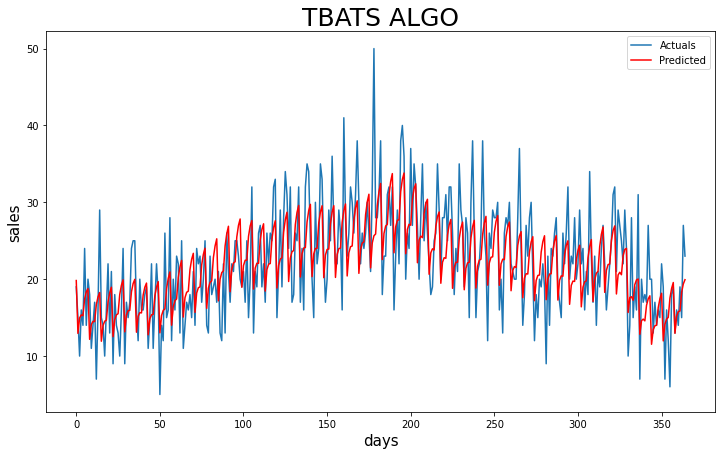

In [17]:

plt.figure(figsize=(12,7))
plt.plot(y_to_test.to_frame().reset_index()['sales'],label='Actuals')
plt.plot(pd.DataFrame(y_forecast), color='red',label='Predicted')
plt.legend(loc='upper right')
plt.ylabel('sales',fontsize=15)
plt.xlabel('days',fontsize=15)
plt.title('TBATS ALGO',fontsize=25)
plt.show()

In [18]:
from pmdarima import auto_arima
arima_model = auto_arima(y_to_train, seasonal=True, m=7)
y_arima_forecast = arima_model.predict(n_periods=365)

In [19]:
print('mse of tbat',mean_squared_error(y_arima_forecast,y_to_test))

mse of tbat 71.12308826999354


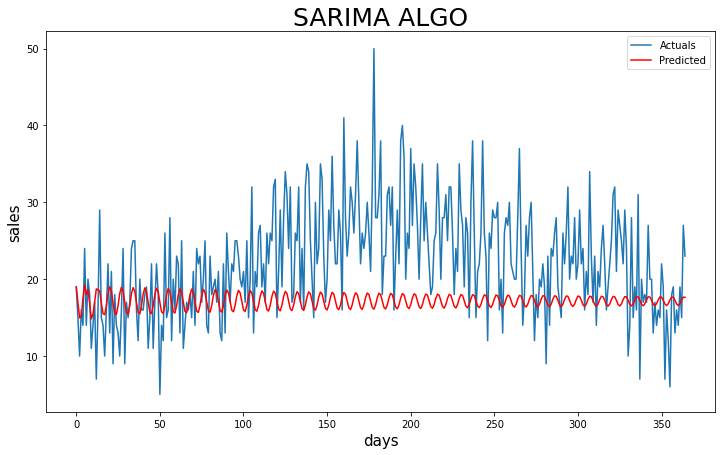

In [22]:
plt.figure(figsize=(12,7))
plt.plot(y_to_test.to_frame().reset_index()['sales'],label='Actuals')
plt.plot(pd.DataFrame(y_arima_forecast), color='red',label='Predicted')
plt.ylabel('sales',fontsize=15)
plt.xlabel('days',fontsize=15)
plt.title('SARIMA ALGO',fontsize=25)
plt.legend(loc='upper right')
plt.show()

In [ ]:
#################################################################################################

In [ ]:
#we move to the problem of outlier detection
#we see from the graphs and the mean squared error that tbats works better than arima

x_to_test['predicted']
y_train['predicted']=pd.DataFrame(y_forecast)


In [ ]:
def detect_classify_anomalies(df,window):
    df.replace([np.inf, -np.inf], np.NaN, inplace=True)
    df.fillna(0,inplace=True)
    df['error']=df['sales']-df['predicted']
    df['percentage_change'] = ((df['sales'] - df['predicted']) / df['actuals']) * 100
    df['meanval'] = df['error'].rolling(window=window).mean()
    df['deviation'] = df['error'].rolling(window=window).std()
    df['-3s'] = df['meanval'] - (2 * df['deviation'])
    df['3s'] = df['meanval'] + (2 * df['deviation'])
    df['-2s'] = df['meanval'] - (1.75 * df['deviation'])
    df['2s'] = df['meanval'] + (1.75 * df['deviation'])
    df['-1s'] = df['meanval'] - (1.5 * df['deviation'])
    df['1s'] = df['meanval'] + (1.5 * df['deviation'])
    cut_list = df[['error', '-3s', '-2s', '-1s', 'meanval', '1s', '2s', '3s']]
    cut_values = cut_list.values
    cut_sort = np.sort(cut_values)
    df['impact'] = [(lambda x: np.where(cut_sort == df['error'][x])[1][0])(x) for x in
                               range(len(df['error']))]
    severity = {0: 3, 1: 2, 2: 1, 3: 0, 4: 0, 5: 1, 6: 2, 7: 3}
    region = {0: "NEGATIVE", 1: "NEGATIVE", 2: "NEGATIVE", 3: "NEGATIVE", 4: "POSITIVE", 5: "POSITIVE", 6: "POSITIVE",
              7: "POSITIVE"}
    df['color'] =  df['impact'].map(severity)
    df['region'] = df['impact'].map(region)
    df['anomaly_points'] = np.where(df['color'] == 3, df['error'], np.nan)
    #df = df.sort_values(by='load_date', ascending=False)
    #df.load_date = pd.to_datetime(df['load_date'].astype(str), format="%Y-%m-%d")
    return df
x_to_test['prec']
df=detect_classify_anomalies(df,7)

In [ ]:
df

In [ ]:
import plotly.graph_objs as go
def plot_anomaly(df,metric_name):
    #error = pd.DataFrame(Order_results.error.values)
    #df = df.sort_values(by='load_date', ascending=False)
    #df.load_date = pd.to_datetime(df['load_date'].astype(str), format="%Y%m%d")
    dates = df.date
    #meanval = error.rolling(window=window).mean()
    #deviation = error.rolling(window=window).std()
    #res = error
#upper_bond=meanval + (2 * deviation)
    #lower_bond=meanval - (2 * deviation)
#anomalies = pd.DataFrame(index=res.index, columns=res.columns)
    #anomalies[res < lower_bond] = res[res < lower_bond]
    #anomalies[res > upper_bond] = res[res > upper_bond]
    bool_array = (abs(df['anomaly_points']) > 0)
#And a subplot of the Actual Values.
    actuals = df["actuals"][-len(bool_array):]
    anomaly_points = bool_array * actuals
    anomaly_points[anomaly_points == 0] = np.nan
#Order_results['meanval']=meanval
    #Order_results['deviation']=deviation
    color_map= {0: "green", 1: "yellow", 2: "orange", 3: "red"}
    table = go.Table(
    domain=dict(x=[0, 1],
                y=[0, 0.3]),
    columnwidth=[1, 2 ],
    #columnorder=[0, 1, 2,],
    header = dict(height = 20,
                  values = [['<b>Date</b>'],['<b>Actual Values </b>'],
                            ['<b>Predicted</b>'], ['<b>% Difference</b>'],['<b>Severity (0-3)</b>']],
                 font = dict(color=['rgb(45, 45, 45)'] * 5, size=14),
                  fill = dict(color='#d562be')),
    cells = dict(values = [df.round(3)[k].tolist() for k in ['date', 'actuals', 'predicted',
                                                               'percentage_change','color']],
                 line = dict(color='#506784'),
                 align = ['center'] * 5,
                 font = dict(color=['rgb(40, 40, 40)'] * 5, size=12),
                 #format = [None] + [",.4f"] + [',.4f'],
#suffix=[None] * 4,
                 suffix=[None] + [''] + [''] + ['%'] + [''],
                 height = 27,
                 #fill = dict(color=['rgb(235, 193, 238)', 'rgba(228, 222, 249, 0.65)']))
                 ## ['rgb(245,245,245)',#unique color for the first column
                 fill=dict(color=  
                      [df['color'].map(color_map)],
                      )
    ))
#df['ano'] = np.where(df['color']==3, df['error'], np.nan)
    anomalies = go.Scatter(name="Anomaly",
                       x=dates,
                       xaxis='x1',
                       yaxis='y1',
                       y=df['anomaly_points'],
                       mode='markers',
                       marker = dict(color ='red',
                      size = 11,lines = dict(
                                         color = "red",
                                         width = 2)))
    upper_bound = go.Scatter(hoverinfo="skip",
                         x=dates,
                         showlegend =False,
                         xaxis='x1',
                         yaxis='y1',
                         y=df['3s'],
                         marker=dict(color="#444"),
                         line=dict(
                             color=('rgb(23, 96, 167)'),
                             width=2,
                             dash='dash'),
                         fillcolor='rgba(68, 68, 68, 0.3)',
                         fill='tonexty')
    lower_bound = go.Scatter(name='Confidence Interval',
                          x=dates,
                         xaxis='x1',
                         yaxis='y1',
                          y=df['-3s'],
                          marker=dict(color="#444"),
                          line=dict(
                              color=('rgb(23, 96, 167)'),
                              width=2,
                              dash='dash'),
                          fillcolor='rgba(68, 68, 68, 0.3)',
                          fill='tonexty')
    Actuals = go.Scatter(name= 'Actuals',
                     x= dates,
                     y= df['actuals'],
                    xaxis='x2', yaxis='y2',
                     mode='line',
                     marker=dict(size=12,
                                 line=dict(width=1),
                                 color="blue"))
    Predicted = go.Scatter(name= 'Predicted',
                     x= dates,
                     y= df['predicted'],
                    xaxis='x2', yaxis='y2',
                     mode='line',
                     marker=dict(size=12,
                                 line=dict(width=1),
                                 color="orange"))
# create plot for error...
    Error = go.Scatter(name="Error",
                   x=dates, y=df['error'],
                   xaxis='x1',
                   yaxis='y1',
                   mode='line',
                   marker=dict(size=12,
                               line=dict(width=1),
                               color="red"),
                   text="Error")
    anomalies_map = go.Scatter(name = "anomaly actual",
                                   showlegend=False,
                                   x=dates,
                                   y=anomaly_points,
                                   mode='markers',
                                   xaxis='x2',
                                   yaxis='y2',
                                    marker = dict(color ="red",
                                  size = 11,
                                 line = dict(
                                     color = "red",
                                     width = 2)))
    Mvingavrg = go.Scatter(name="Moving Average",
                           x=dates,
                           y=df['meanval'],
                           mode='line',
                           xaxis='x1',
                           yaxis='y1',
                           marker=dict(size=12,
                                       line=dict(width=1),
                                       color="green"),
                           text="Moving average")
    axis=dict(
    showline=True,
    zeroline=False,
    showgrid=True,
    mirror=True,
    ticklen=4,
    gridcolor='#ffffff',
    tickfont=dict(size=10))
    layout = dict(
    width=1000,
    height=865,
    autosize=False,
    title= metric_name,
    margin = dict(t=75),
    showlegend=True,
    xaxis1=dict(axis, **dict(domain=[0, 1], anchor='y1', showticklabels=True)),
    xaxis2=dict(axis, **dict(domain=[0, 1], anchor='y2', showticklabels=True)),
    yaxis1=dict(axis, **dict(domain=[2 * 0.21 + 0.20 + 0.09, 1], anchor='x1', hoverformat='.2f')),
    yaxis2=dict(axis, **dict(domain=[0.21 + 0.12, 2 * 0.31 + 0.02], anchor='x2', hoverformat='.2f')))
    fig = go.Figure(data = [table,anomalies,anomalies_map,
                        upper_bound,lower_bound,Actuals,Predicted,
                        Mvingavrg,Error], layout = layout)
    iplot(fig)
    pyplot.show()
    classify_df=detect_classify_anomalies(predicted_df,7)
    classify_df.reset_index(inplace=True)
    del classify_df['index']
    plot_anomaly(classify_df,"metric_name")

In [ ]:
plot_anomaly(df,'MSE')

In [ ]:
!pip install plotly==2.7.0